#IMPORT NECESSARY LIBRARIES

In [1]:
import os
import random
random.seed(42) # Set random seed for reproducibility
import time
import math
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

/tmp/ipykernel_4009699/2250032840.py:11: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
from mpl_toolkits.mplot3d import Axes3D
from skimage import io
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import VotingClassifier
from imblearn.over_sampling import RandomOverSampler
import imgaug.augmenters as iaa

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, OneCycleLR
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
import torch.multiprocessing as mp
from torchvision import models, transforms
from PIL import Image
from tqdm import tqdm

/storage/phucpg/venv/v1/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


##Define runtime

In [4]:
# !pip install ipython-autotime
%load_ext autotime

time: 314 µs (started: 2024-08-13 17:03:12 +07:00)


##Define GPU usage

In [5]:
print("Available GPUs:")
for i in range(torch.cuda.device_count()):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)}")


Available GPUs:
GPU 0: Tesla K80
GPU 1: Tesla K80
GPU 2: Tesla K80
GPU 3: Tesla K80
GPU 4: Tesla K80
GPU 5: Tesla K80
GPU 6: Tesla K80
GPU 7: Tesla K80
time: 160 ms (started: 2024-08-13 17:03:12 +07:00)


In [6]:
# Set the GPU device
gpu_index = 3  # Change the index for each file (0 to 7)
if gpu_index < torch.cuda.device_count():
    torch.cuda.set_device(gpu_index)
    device = torch.device(f"cuda:{gpu_index}")
    print(f"Using GPU {gpu_index}: {torch.cuda.get_device_name(gpu_index)}")
else:
    print(f"Invalid GPU index: {gpu_index}. Please choose an index between 0 and {torch.cuda.device_count() - 1}.")


Using GPU 3: Tesla K80
time: 2.89 ms (started: 2024-08-13 17:03:12 +07:00)


#DATA PREPARATION

##Get and Import dataset

In [7]:
data_dir = '../data/ISIC_2019'

training_input_zip = data_dir + '/ISIC_2019_Training_Input.zip'
test_input_zip = data_dir + '/ISIC_2019_Test_Input.zip'

training_Metadata = data_dir + '/ISIC_2019_Training_Metadata.csv'
training_GroundTruth =  data_dir + '/ISIC_2019_Training_GroundTruth.csv'
test_Metadata = data_dir + '/ISIC_2019_Test_Metadata.csv'

# !unzip "$training_input_zip"
# !unzip "$test_input_zip"

training_input_dir = data_dir + '/ISIC_2019_Training_Input'
test_input_dir = data_dir + '/ISIC_2019_Test_Input'

time: 3.86 ms (started: 2024-08-13 17:03:12 +07:00)


###Meta-data

In [8]:
train_metadata=pd.read_csv(training_Metadata)
train_metadata

,image,age_approx,anatom_site_general,lesion_id,sex
0,ISIC_0000000,55.0,anterior torso,NaN,female
1,ISIC_0000001,30.0,anterior torso,NaN,female
2,ISIC_0000002,60.0,upper extremity,NaN,female
3,ISIC_0000003,30.0,upper extremity,NaN,male
4,ISIC_0000004,80.0,posterior torso,NaN,male
...,...,...,...,...,...
25326,ISIC_0073247,85.0,head/neck,BCN_0003925,female
25327,ISIC_0073248,65.0,anterior torso,BCN_0001819,male
25328,ISIC_0073249,70.0,lower extremity,BCN_0001085,male
25329,ISIC_0073251,55.0,palms/soles,BCN_0002083,female


time: 96.7 ms (started: 2024-08-13 17:03:12 +07:00)


In [9]:
train_groundtruth=pd.read_csv(training_GroundTruth)
# # Drop the 'UNK' column
# train_groundtruth = train_groundtruth.drop(columns=['UNK'])
train_groundtruth

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
25326,ISIC_0073247,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
25327,ISIC_0073248,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
25328,ISIC_0073249,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25329,ISIC_0073251,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


time: 87.8 ms (started: 2024-08-13 17:03:12 +07:00)


In [10]:
test_metadata=pd.read_csv(test_Metadata)
test_metadata

,image,age_approx,anatom_site_general,sex
0,ISIC_0034321,60.0,NaN,female
1,ISIC_0034322,70.0,anterior torso,male
2,ISIC_0034323,70.0,lower extremity,male
3,ISIC_0034324,70.0,lower extremity,male
4,ISIC_0034325,30.0,upper extremity,female
...,...,...,...,...
8233,ISIC_0073236,75.0,anterior torso,male
8234,ISIC_0073243,65.0,lower extremity,male
8235,ISIC_0073250,30.0,anterior torso,female
8236,ISIC_0073252,85.0,head/neck,female


time: 36.3 ms (started: 2024-08-13 17:03:13 +07:00)


###Meta-data information

In [11]:
train_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25331 entries, 0 to 25330
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   image                25331 non-null  object 
 1   age_approx           24894 non-null  float64
 2   anatom_site_general  22700 non-null  object 
 3   lesion_id            23247 non-null  object 
 4   sex                  24947 non-null  object 
dtypes: float64(1), object(4)
memory usage: 989.6+ KB
time: 19.2 ms (started: 2024-08-13 17:03:13 +07:00)


In [12]:
train_groundtruth.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25331 entries, 0 to 25330
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   image   25331 non-null  object 
 1   MEL     25331 non-null  float64
 2   NV      25331 non-null  float64
 3   BCC     25331 non-null  float64
 4   AK      25331 non-null  float64
 5   BKL     25331 non-null  float64
 6   DF      25331 non-null  float64
 7   VASC    25331 non-null  float64
 8   SCC     25331 non-null  float64
 9   UNK     25331 non-null  float64
dtypes: float64(9), object(1)
memory usage: 1.9+ MB
time: 74.1 ms (started: 2024-08-13 17:03:13 +07:00)


In [13]:
test_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8238 entries, 0 to 8237
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   image                8238 non-null   object 
 1   age_approx           7912 non-null   float64
 2   anatom_site_general  7583 non-null   object 
 3   sex                  7899 non-null   object 
dtypes: float64(1), object(3)
memory usage: 257.6+ KB
time: 29.7 ms (started: 2024-08-13 17:03:13 +07:00)


##DATA PREPROCESSING

###Original data information

In [14]:
train_metadata.info()
print()
# train_metadata.head()
print(train_metadata.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25331 entries, 0 to 25330
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   image                25331 non-null  object 
 1   age_approx           24894 non-null  float64
 2   anatom_site_general  22700 non-null  object 
 3   lesion_id            23247 non-null  object 
 4   sex                  24947 non-null  object 
dtypes: float64(1), object(4)
memory usage: 989.6+ KB

Index(['image', 'age_approx', 'anatom_site_general', 'lesion_id', 'sex'], dtype='object')
time: 13.7 ms (started: 2024-08-13 17:03:13 +07:00)


###Data cleansing

identifying and correcting errors or inconsistencies in the data.

In [15]:
# Convert the train_groundtruth DataFrame from wide format to long format
melted_groundtruth = train_groundtruth.melt(id_vars='image', var_name='disease_type', value_name='presence')


# THIS LINE REMOVE UNK COLUMN
# Filter out rows where presence is 0 (i.e., the disease type is not present)
filtered_groundtruth = melted_groundtruth[melted_groundtruth['presence'] == 1]

# Merge the train_metadata and filtered_groundtruth DataFrames on the 'image' column
combined_train_df = pd.merge(train_metadata, filtered_groundtruth, on='image')

print(combined_train_df.columns)

Index(['image', 'age_approx', 'anatom_site_general', 'lesion_id', 'sex',
       'disease_type', 'presence'],
      dtype='object')
time: 91 ms (started: 2024-08-13 17:03:13 +07:00)


In [16]:
# Removing duplicate rows
train_metadata_pp = combined_train_df.drop_duplicates()

# Removing rows with missing values
train_metadata_pp = train_metadata_pp.dropna()

# Replace missing values in 'age' column with median age
median_age = train_metadata_pp['age_approx'].median()
train_metadata_pp['age_approx'] = train_metadata_pp['age_approx'].fillna(median_age)

# Fixing column names
train_metadata_pp = train_metadata_pp.rename(columns={
    'image': 'Image_Id',
    'age_approx': 'Age',
    'anatom_site_general': 'Region_Of_Disease',
    'lesion_id': 'Lesion_Id',
    'sex': 'Sex',
    'disease_type': 'Disease_Type',
    'presence': 'Presence'
})

# Define the mapping of current values to new values
diagnosis_mapping = {
    'MEL': 'Melanoma',
    'NV': 'Melanocytic Nevi',
    'BCC': 'Basal Cell Carcinoma',
    'AK': 'Actinic Keratoses',
    'BKL': 'Benign Keratosis-Like Lesions',
    'DF': 'Dermatofibroma',
    'VASC': 'Vascular Lesions',
    'SCC': 'Squamous Cell Carcinoma',
    'UNK': 'Unknown'
}

# Convert the Age column to integers
train_metadata_pp['Age'] = train_metadata_pp['Age'].astype(int)

# Create a new column with the updated diagnosis names
train_metadata_pp['Diagnosis'] = train_metadata_pp['Disease_Type'].map(diagnosis_mapping)

time: 61.3 ms (started: 2024-08-13 17:03:13 +07:00)


In [17]:
train_metadata_pp.info()
print()
train_metadata_pp

<class 'pandas.core.frame.DataFrame'>
Index: 21311 entries, 1459 to 25330
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Image_Id           21311 non-null  object 
 1   Age                21311 non-null  int64  
 2   Region_Of_Disease  21311 non-null  object 
 3   Lesion_Id          21311 non-null  object 
 4   Sex                21311 non-null  object 
 5   Disease_Type       21311 non-null  object 
 6   Presence           21311 non-null  float64
 7   Diagnosis          21311 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 1.5+ MB



,Image_Id,Age,Region_Of_Disease,Lesion_Id,Sex,Disease_Type,Presence,Diagnosis
1459,ISIC_0012653_downsampled,50,posterior torso,MSK4_0011169,female,NV,1.0,Melanocytic Nevi
1460,ISIC_0012654_downsampled,30,lower extremity,MSK4_0011170,female,NV,1.0,Melanocytic Nevi
1461,ISIC_0012655_downsampled,35,upper extremity,MSK4_0011171,female,NV,1.0,Melanocytic Nevi
1462,ISIC_0012656_downsampled,45,posterior torso,MSK4_0011172,male,NV,1.0,Melanocytic Nevi
1463,ISIC_0012657_downsampled,20,upper extremity,MSK4_0011173,female,NV,1.0,Melanocytic Nevi
...,...,...,...,...,...,...,...,...
25326,ISIC_0073247,85,head/neck,BCN_0003925,female,BCC,1.0,Basal Cell Carcinoma
25327,ISIC_0073248,65,anterior torso,BCN_0001819,male,BKL,1.0,Benign Keratosis-Like Lesions
25328,ISIC_0073249,70,lower extremity,BCN_0001085,male,MEL,1.0,Melanoma
25329,ISIC_0073251,55,palms/soles,BCN_0002083,female,NV,1.0,Melanocytic Nevi


time: 32.5 ms (started: 2024-08-13 17:03:13 +07:00)


###Get images data

finish preprocessing

In [18]:
# Map image paths
train_image_dir = training_input_dir
image_paths = [os.path.join(train_image_dir, fname) for fname in os.listdir(train_image_dir)]
image_path_dict = {os.path.splitext(os.path.basename(p))[0]: p for p in image_paths}
train_metadata_pp['Image_path'] = train_metadata_pp['Image_Id'].map(image_path_dict)

train_metadata_pp

,Image_Id,Age,Region_Of_Disease,Lesion_Id,Sex,Disease_Type,Presence,Diagnosis,Image_path
1459,ISIC_0012653_downsampled,50,posterior torso,MSK4_0011169,female,NV,1.0,Melanocytic Nevi,../data/ISIC_2019/ISIC_2019_Training_Input/ISI...
1460,ISIC_0012654_downsampled,30,lower extremity,MSK4_0011170,female,NV,1.0,Melanocytic Nevi,../data/ISIC_2019/ISIC_2019_Training_Input/ISI...
1461,ISIC_0012655_downsampled,35,upper extremity,MSK4_0011171,female,NV,1.0,Melanocytic Nevi,../data/ISIC_2019/ISIC_2019_Training_Input/ISI...
1462,ISIC_0012656_downsampled,45,posterior torso,MSK4_0011172,male,NV,1.0,Melanocytic Nevi,../data/ISIC_2019/ISIC_2019_Training_Input/ISI...
1463,ISIC_0012657_downsampled,20,upper extremity,MSK4_0011173,female,NV,1.0,Melanocytic Nevi,../data/ISIC_2019/ISIC_2019_Training_Input/ISI...
...,...,...,...,...,...,...,...,...,...
25326,ISIC_0073247,85,head/neck,BCN_0003925,female,BCC,1.0,Basal Cell Carcinoma,../data/ISIC_2019/ISIC_2019_Training_Input/ISI...
25327,ISIC_0073248,65,anterior torso,BCN_0001819,male,BKL,1.0,Benign Keratosis-Like Lesions,../data/ISIC_2019/ISIC_2019_Training_Input/ISI...
25328,ISIC_0073249,70,lower extremity,BCN_0001085,male,MEL,1.0,Melanoma,../data/ISIC_2019/ISIC_2019_Training_Input/ISI...
25329,ISIC_0073251,55,palms/soles,BCN_0002083,female,NV,1.0,Melanocytic Nevi,../data/ISIC_2019/ISIC_2019_Training_Input/ISI...


time: 9.37 s (started: 2024-08-13 17:03:15 +07:00)


In [19]:
# train_metadata_pp = train_metadata_pp.sample(n=5000, random_state=42) # remove this line for full dataset
train_metadata_pp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21311 entries, 1459 to 25330
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Image_Id           21311 non-null  object 
 1   Age                21311 non-null  int64  
 2   Region_Of_Disease  21311 non-null  object 
 3   Lesion_Id          21311 non-null  object 
 4   Sex                21311 non-null  object 
 5   Disease_Type       21311 non-null  object 
 6   Presence           21311 non-null  float64
 7   Diagnosis          21311 non-null  object 
 8   Image_path         21311 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 1.6+ MB
time: 23.9 ms (started: 2024-08-13 17:03:24 +07:00)


###Correctting image paths

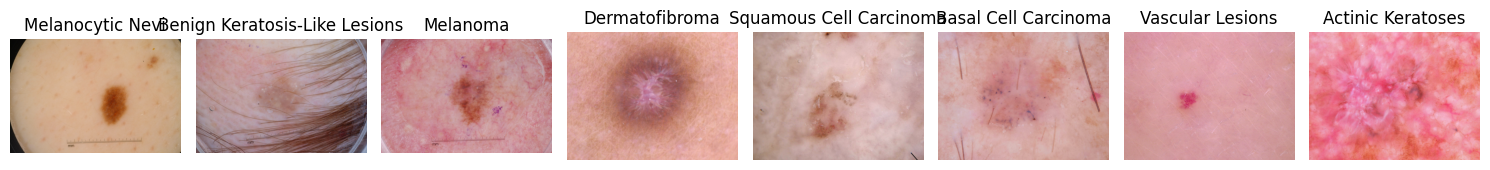

time: 28.6 s (started: 2024-08-13 17:03:24 +07:00)


In [20]:
# Ensure that the image paths are correct and accessible
for i in range(len(train_metadata_pp)):
    if not os.path.isfile(train_metadata_pp['Image_path'].iloc[i]):
        raise FileNotFoundError(f"Image file not found: {train_metadata_pp['Image_path'].iloc[i]}")

# Get one image per class
class_images = train_metadata_pp.drop_duplicates(subset='Diagnosis')

# Plot one image per class
def plot_class_images(class_images):
    plt.figure(figsize=(15, 5))
    num_classes = len(class_images)
    for i in range(num_classes):
        plt.subplot(1, num_classes, i + 1)
        img = plt.imread(class_images['Image_path'].iloc[i])
        plt.imshow(img)
        plt.axis('off')
        plt.title(class_images['Diagnosis'].iloc[i], fontsize=12)
    plt.tight_layout()
    plt.show()

# Call the function to plot images
plot_class_images(class_images)

#MODEL IMPLEMENTATION

##Prepare data for training process

###Label Encoder

In [21]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit LabelEncoder and transform 'Region_Of_Disease' column
train_metadata_pp['Diagnosis_Label'] = label_encoder.fit_transform(train_metadata_pp['Diagnosis'])

# Display the mapping between original labels and encoded labels
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Encoding Mapping:")
print(label_mapping)

Label Encoding Mapping:
{'Actinic Keratoses': 0, 'Basal Cell Carcinoma': 1, 'Benign Keratosis-Like Lesions': 2, 'Dermatofibroma': 3, 'Melanocytic Nevi': 4, 'Melanoma': 5, 'Squamous Cell Carcinoma': 6, 'Vascular Lesions': 7}
time: 14.1 ms (started: 2024-08-13 17:03:53 +07:00)


###Augment and transfrom dataset

In [22]:
# Data augmentation and transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),  # Convert PIL image to tensor
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(224, scale=(0.9, 1.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

time: 18.2 ms (started: 2024-08-13 17:03:53 +07:00)


###Split data

In [23]:
# Split the dataset into train and temp (80% train, 20% temp)
train_df, temp_df = train_test_split(train_metadata_pp, test_size=0.2, stratify=train_metadata_pp['Diagnosis_Label'], random_state=42)

# Split the temp dataset into validation and test (50% val, 50% test of the 20% temp)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['Diagnosis_Label'], random_state=42)

print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

Training set size: 17048
Validation set size: 2131
Test set size: 2132
time: 40.4 ms (started: 2024-08-13 17:03:53 +07:00)


###Balancing dataset

In [24]:
# Separate features and labels for balancing
X_train = train_df.drop(columns=['Diagnosis_Label'])
y_train = train_df['Diagnosis_Label']

# Apply RandomOverSampler only to the training set
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

# Combine resampled features and labels into a DataFrame
train_df_resampled = X_resampled.copy()
train_df_resampled['Diagnosis_Label'] = y_resampled

print(f"Resampled training set size: {len(train_df_resampled)}")

Resampled training set size: 62368
time: 115 ms (started: 2024-08-13 17:03:53 +07:00)


###Custom dataset class

In [25]:
#  make easily load and preprocess dataset -> compatible with PyTorch’s data loading utilities.
class LoadedDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['Image_path']
        image = Image.open(img_path).convert('RGB')
        label = self.dataframe.iloc[idx]['Diagnosis_Label']

        if self.transform:
            image = self.transform(image)

        return image, label

# Create datasets and dataloaders
train_dataset = LoadedDataset(train_df_resampled, transform=transform)
val_dataset = LoadedDataset(val_df, transform=transform)
test_dataset = LoadedDataset(test_df, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

# Example of iterating through the dataloader and printing results
for images, labels in train_loader:
    print(f"Batch of images shape: {images.shape}")
    print(f"Batch of labels shape: {labels.shape}")
    print(f"Labels: {labels}")

    print("Label Mapping:", label_mapping)
    print("Unique Labels in Dataset:", train_metadata_pp['Diagnosis_Label'].unique())

    break  # Print only the first batch

Batch of images shape: torch.Size([64, 3, 224, 224])
Batch of labels shape: torch.Size([64])
Labels: tensor([7, 6, 4, 2, 1, 5, 2, 0, 1, 6, 6, 1, 5, 4, 0, 4, 3, 7, 2, 3, 5, 3, 2, 5,
        4, 1, 2, 6, 3, 3, 5, 0, 5, 7, 0, 3, 6, 2, 3, 7, 4, 2, 6, 2, 6, 6, 4, 6,
        4, 4, 7, 6, 7, 2, 3, 1, 4, 5, 4, 3, 4, 4, 0, 4])
Label Mapping: {'Actinic Keratoses': 0, 'Basal Cell Carcinoma': 1, 'Benign Keratosis-Like Lesions': 2, 'Dermatofibroma': 3, 'Melanocytic Nevi': 4, 'Melanoma': 5, 'Squamous Cell Carcinoma': 6, 'Vascular Lesions': 7}
Unique Labels in Dataset: [4 2 5 3 6 1 7 0]
time: 7.52 s (started: 2024-08-13 17:03:53 +07:00)


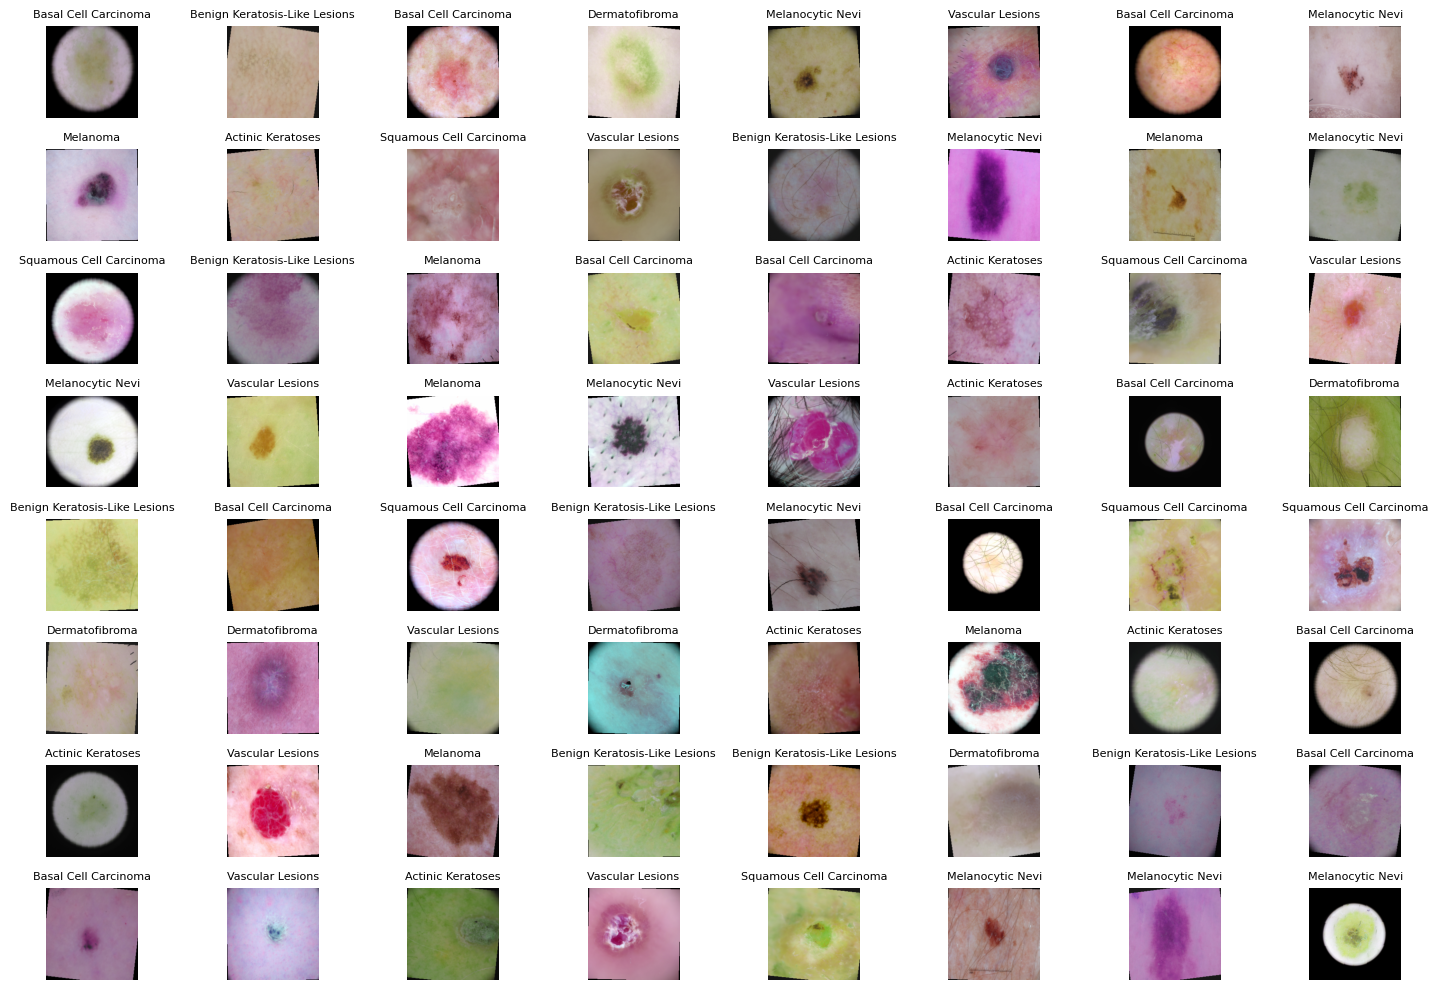

time: 15.4 s (started: 2024-08-13 17:04:01 +07:00)


In [26]:
# Function to plot a batch of images
def plot_batch_images(images, labels, label_mapping):
    num_images = len(images)
    num_cols = 8
    num_rows = math.ceil(num_images / num_cols)

    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        plt.subplot(num_rows, num_cols, i + 1)

        img = images[i].permute(1, 2, 0).numpy()  # Convert tensor to numpy array and rearrange dimensions
        img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # Unnormalize
        img = np.clip(img, 0, 1)  # Clip values to be in the range [0, 1]
        plt.imshow(img)
        plt.axis('off')

        label = labels[i].item()
        label_name = list(label_mapping.keys())[list(label_mapping.values()).index(label)]  # Get label name
        plt.title(label_name, fontsize=8)

    plt.tight_layout()
    plt.show()

# Get a batch of training data
images, labels = next(iter(train_loader))

# Plot the batch of images
plot_batch_images(images, labels, label_mapping)


##Model functionalities

###Load pre-trained and construct models

####Load pretrained models

In [27]:
def create_model(model_name, num_classes):
    if model_name == 'resnet50':
        model = models.resnet50(pretrained=True)
        num_ftrs = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Dropout(0.5),  # Add dropout with 50% probability
            nn.Linear(num_ftrs, num_classes)
        )
    elif model_name == 'densenet':
        model = models.densenet121(pretrained=True)
        num_ftrs = model.classifier.in_features
        model.classifier = nn.Sequential(
            nn.Dropout(0.5),  # Add dropout with 50% probability
            nn.Linear(num_ftrs, num_classes)
        )
    elif model_name == 'mobilenetv2':
        model = models.mobilenet_v2(pretrained=True)
        num_ftrs = model.classifier[1].in_features
        model.classifier[1] = nn.Sequential(
            nn.Dropout(0.5),  # Add dropout with 50% probability
            nn.Linear(num_ftrs, num_classes)
        )
    elif model_name == 'resnext50':
        model = models.resnext50_32x4d(pretrained=True)
        num_ftrs = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Dropout(0.5),  # Add dropout with 50% probability
            nn.Linear(num_ftrs, num_classes)
        )
    elif model_name == 'squeezenet':
        model = models.squeezenet1_0(pretrained=True)
        model.classifier[1] = nn.Sequential(
            nn.Dropout(0.5),  # Add dropout with 50% probability
            nn.Conv2d(512, num_classes, kernel_size=(1, 1), stride=(1, 1))
        )
        model.num_classes = num_classes
    elif model_name == 'customCNN':
        model = CustomCNN(num_classes)
    else:
        raise ValueError("Invalid model name. Choose from 'resnet50v2', 'efficientnet', 'densenet', 'mobilenetv2', 'nasnetmobile', 'resnext50', 'squeezenet', or 'customCNN'.")
    return model


time: 2.39 ms (started: 2024-08-13 17:04:16 +07:00)


###Training activities

In [28]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=25, patience=5):
    best_val_loss = np.inf
    patience_counter = 0
    metrics = {
        'Train Loss': [],
        'Train Accuracy': [],
        'Val Loss': [],
        'Val Accuracy': []
    }

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", ncols=200)  # Adjust ncols to set the width
        num_batches = len(train_loader)
        validate_every_n_batches = max(1, num_batches // 10)  # Calculate the number of batches for 10% progress

        val_loss = None
        val_acc = None

        for batch_idx, (images, labels) in enumerate(progress_bar):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()  # Backpropagation
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            train_loss = running_loss / (batch_idx + 1)
            train_acc = 100 * correct / total

            if (batch_idx + 1) % validate_every_n_batches == 0 or (batch_idx + 1) == num_batches:
                val_loss, val_acc, _, _ = validate_model(model, val_loader, criterion)

            progress_bar.set_postfix({
                'Train Loss': f'{train_loss:.4f}',
                'Train Accuracy': f'{train_acc:.2f}%',
                'Val Loss': f'{val_loss:.4f}' if val_loss is not None else '[]',
                'Val Accuracy': f'{val_acc:.2f}%' if val_acc is not None else '[]'
            })
            progress_bar.refresh()

        val_loss, val_acc, all_preds, all_labels = validate_model(model, val_loader, criterion)

        # Store final metrics for the epoch
        metrics['Train Loss'].append(train_loss)
        metrics['Train Accuracy'].append(train_acc)
        metrics['Val Loss'].append(val_loss)
        metrics['Val Accuracy'].append(val_acc)

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print("Early stopping triggered")
            break

    # Print overall model accuracy on the validation set
    print(f"Overall Validation Accuracy: {val_acc:.2f}%")
    
    return metrics


time: 8.15 ms (started: 2024-08-13 17:04:16 +07:00)


In [29]:
def validate_model(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_loss = running_loss / len(val_loader)
    val_acc = 100 * correct / total

    return val_loss, val_acc, all_preds, all_labels


time: 3.41 ms (started: 2024-08-13 17:04:16 +07:00)


###Visualize training result

In [30]:
def plot_metrics(metrics):
    epochs = range(1, len(metrics['Train Loss']) + 1)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, metrics['Train Loss'], label='Train Loss')
    plt.plot(epochs, metrics['Val Loss'], label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.subplot(1, 2, 2)
    plt.plot(epochs, metrics['Train Accuracy'], label='Train Accuracy')
    plt.plot(epochs, metrics['Val Accuracy'], label='Val Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    plt.show()

time: 1.68 ms (started: 2024-08-13 17:04:16 +07:00)


In [31]:
def visualize_predictions(model, val_loader, label_mapping, criterion, num_images=16):
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(15, 15))  # Decrease the figure size

    with torch.no_grad():
        for i, (images, labels) in enumerate(val_loader):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            for j in range(images.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 4, 4, images_so_far)
                ax.axis('off')
                ax.set_title(f'Predicted: {list(label_mapping.keys())[preds[j]]}\n'
                             f'Actual: {list(label_mapping.keys())[labels[j]]}\n'
                             f'Loss: {loss.item():.2f}\n'
                             f'Accuracy: {(preds[j] == labels[j]).item() * 100:.2f}%', fontsize=14)  # Increase text size
                img = images.cpu().data[j].numpy().transpose((1, 2, 0))
                img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
                img = np.clip(img, 0, 1)
                ax.imshow(img)

                if images_so_far == num_images:
                    plt.tight_layout()
                    return


time: 3.93 ms (started: 2024-08-13 17:04:16 +07:00)


In [32]:
def plot_confusion_matrix(model, test_loader, label_mapping):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    cm_labels = list(label_mapping.keys())

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=cm_labels, yticklabels=cm_labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

time: 2.56 ms (started: 2024-08-13 17:04:16 +07:00)


In [33]:
def plot_normalize_confusion_matrix(model, test_loader, label_mapping):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    cm_labels = list(label_mapping.keys())

    # Normalize the confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Plot normalized confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=cm_labels, yticklabels=cm_labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Normalized Confusion Matrix')
    plt.show()

time: 3.22 ms (started: 2024-08-13 17:04:16 +07:00)


##Train the model

In [34]:
# Configuration for training process
num_classes = len(label_mapping)

model_name = 'squeezenet'  # Change this to 'inceptionv3', 'efficientnet' or 'customCNN' if needed

model = create_model(model_name, num_classes)
model = model.to(device)  # Move the model to the device

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)  # Transfer learning model

# Start training
num_epochs = 50
metrics = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs)

Downloading: "https://download.pytorch.org/models/squeezenet1_0-a815701f.pth" to /home/phucpg/.cache/torch/hub/checkpoints/squeezenet1_0-a815701f.pth
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4.79M/4.79M [00:00<00:00, 9.87MB/s]
Epoch 20/50: 100%|████████████████████████████████████████████████████████████████████| 975/975 [14:48<00:00,  1.10it/s, Train Loss=0.3033, Train Accuracy=89.04%, Val Loss=0.9560, Val Accuracy=70.58%]


Early stopping triggered
Overall Validation Accuracy: 71.14%
time: 8h 45min 48s (started: 2024-08-13 17:04:16 +07:00)


##Visualize training result

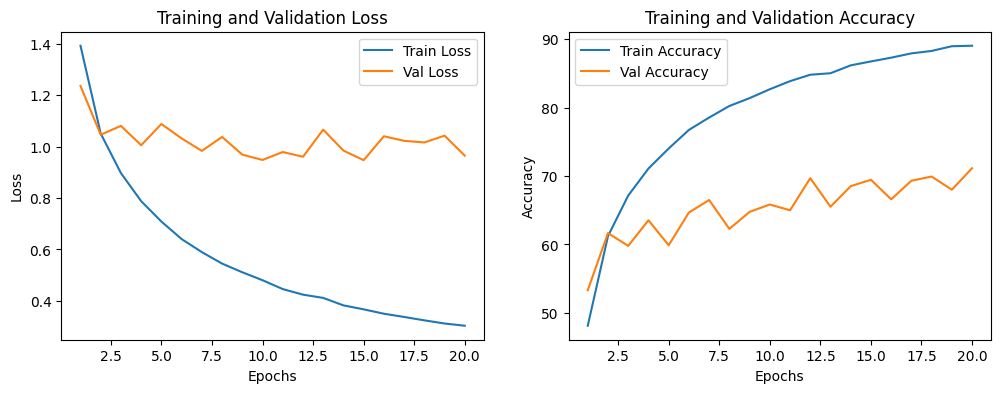

time: 335 ms (started: 2024-08-14 01:50:05 +07:00)


In [35]:
# Visualize the metrics
plot_metrics(metrics)

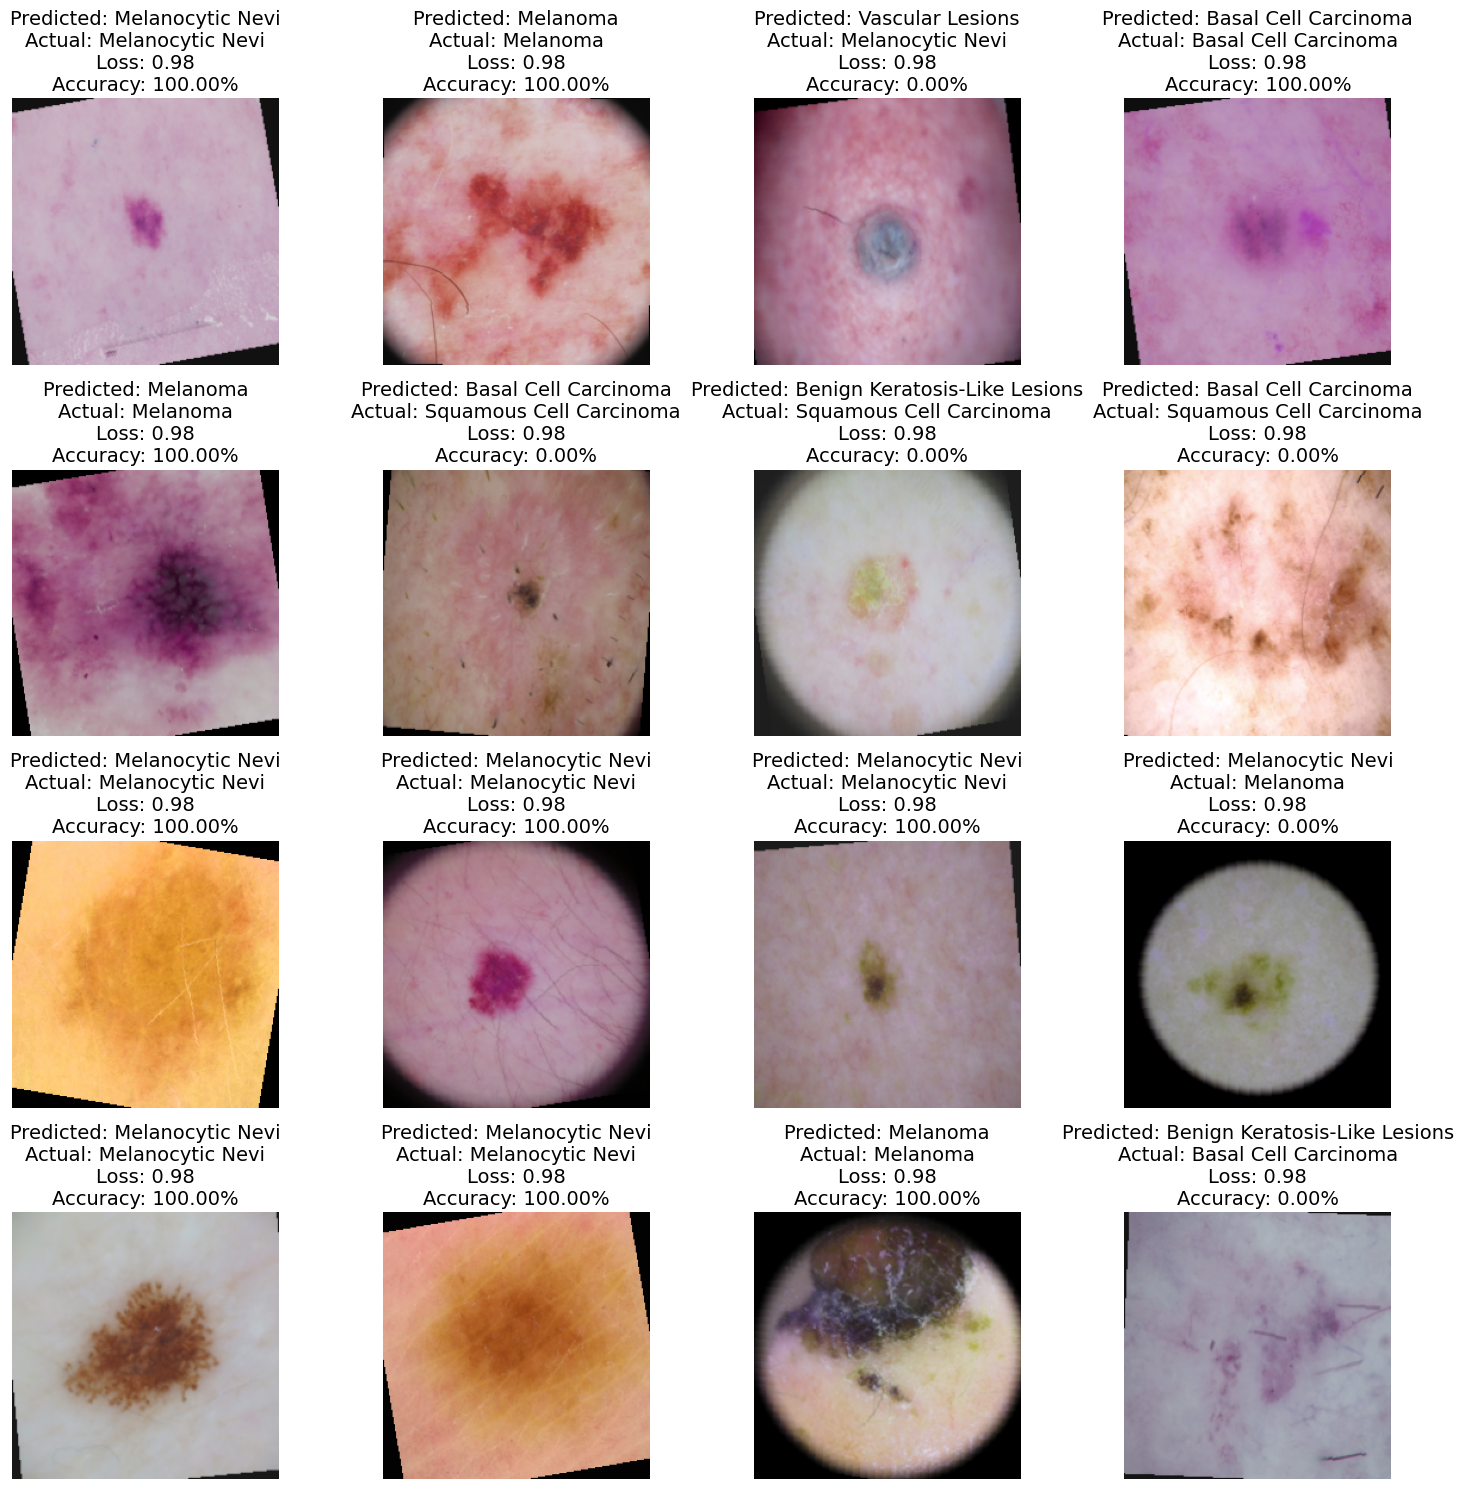

time: 6.98 s (started: 2024-08-14 01:50:05 +07:00)


In [36]:
# Visualize predictions
visualize_predictions(model, val_loader, label_mapping, criterion, num_images=16)

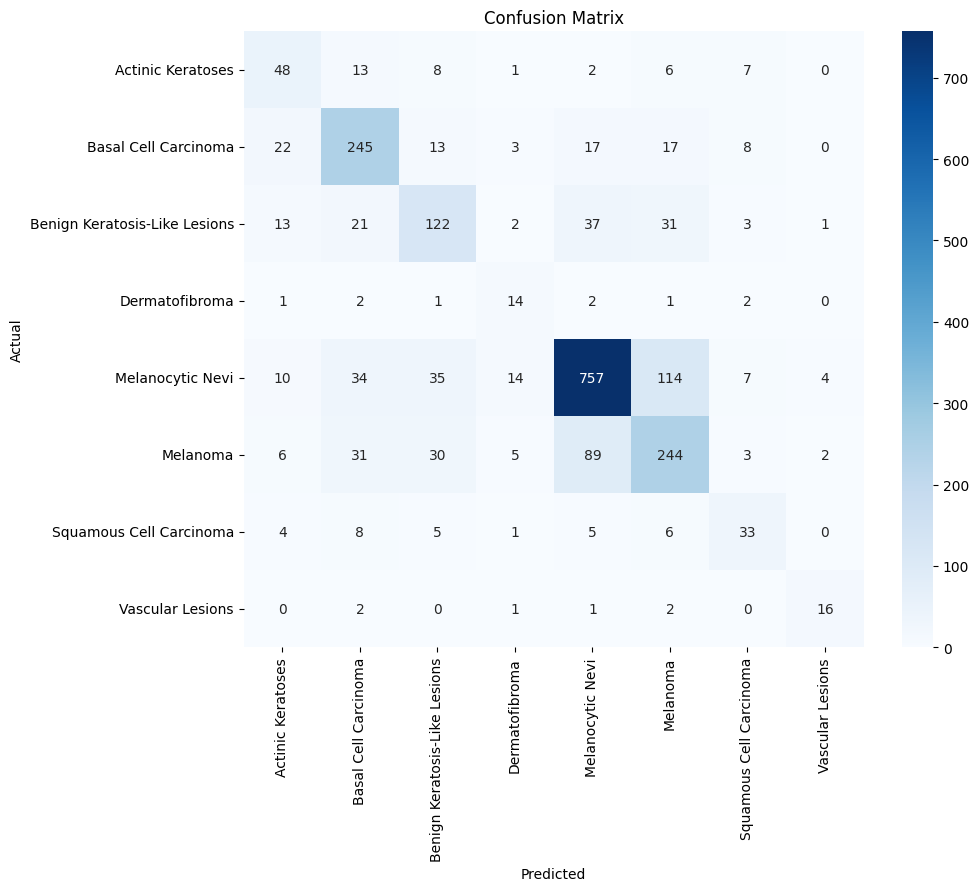

time: 26.2 s (started: 2024-08-14 01:50:12 +07:00)


In [37]:
# Plot the confusion matrix
plot_confusion_matrix(model, test_loader, label_mapping)

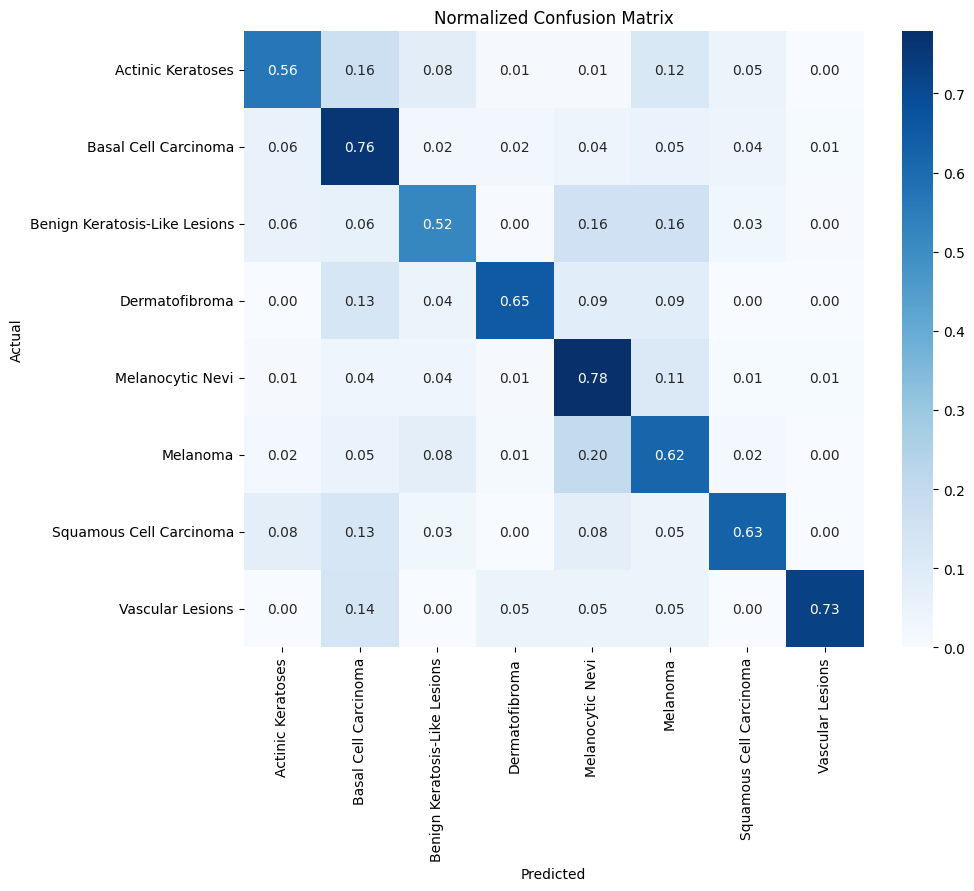

time: 34.2 s (started: 2024-08-14 01:50:38 +07:00)


In [38]:
# Plot the normalized confusion matrix
plot_normalize_confusion_matrix(model, test_loader, label_mapping)

##Save trained model

###Functionalities

In [68]:
def save_model(model, model_name, save_dir):
    # Create the directory if it doesn't exist
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
        print(f"Directory '{save_dir}' created.")

    model_save_path = f'{save_dir}/{model_name}.pth'

    if os.path.exists(model_save_path):
        print(f"Model '{model_name}.pth' already exists.")
        print("Do you want to overwrite it? (1 for Yes, 0 for No): ", end='', flush=True)

        start_time = time.time()
        overwrite = None

        while True:
            if time.time() - start_time > 15:  # 5 minutes = 300 seconds timeout
                print("\nNo input received. Saving model with a new name.")
                overwrite = '0'
                break

            if overwrite is None:
                overwrite = input()

            if overwrite == '1':
                torch.save({'model_name': model_name, 'state_dict': model.state_dict()}, model_save_path)
                print(f"Model '{model_name}' overwritten and saved to {model_save_path}")
                return
            else:
                # Find a new name with an increasing number
                i = 1
                new_model_save_path = f'{save_dir}/{model_name}_{i}.pth'
                while os.path.exists(new_model_save_path):
                    i += 1
                    new_model_save_path = f'{save_dir}/{model_name}_{i}.pth'
                torch.save({'model_name': model_name, 'state_dict': model.state_dict()}, new_model_save_path)
                print(f"Model saved to {new_model_save_path}")
                return
    else:
        torch.save({'model_name': model_name, 'state_dict': model.state_dict()}, model_save_path)
        print(f"Model saved to {model_save_path}")

time: 3.02 ms (started: 2024-08-13 00:10:18 +07:00)


###To save the trained model

In [67]:
# Save the model
save_dir = 'saved_models'
# save_model_name = 'efficientnet'
save_model_name = model_name
save_model(model, save_model_name, save_dir)

Model saved to saved_models/densenet.pth
time: 721 ms (started: 2024-08-13 00:09:58 +07:00)


#TEST THE MODELS

##Get saved model

###Functionalities

In [ ]:
def load_models(saved_dir, expected_num_classes, expected_model_name=None):
    models_dict = {}

    def get_base_model_name(model_name):
        return model_name.split('_')[0]

    if expected_model_name:
        # Load a specific model
        model_save_path = f'{saved_dir}/{expected_model_name}.pth'

        # Load the saved model and model name
        model_info = torch.load(model_save_path)
        loaded_model_name = model_info['model_name']

        if get_base_model_name(loaded_model_name) != get_base_model_name(expected_model_name):
            raise ValueError(f"Model name mismatch: expected {expected_model_name}, but got {loaded_model_name}")

        model = create_model(loaded_model_name, expected_num_classes)  # Make sure to create the model architecture first
        model.load_state_dict(model_info['state_dict'])
        model = model.to(device)  # Move the model to the device
        print(f"Model '{expected_model_name}' loaded successfully")

        models_dict[expected_model_name] = model
    else:
        # Load all models
        for filename in os.listdir(saved_dir):
            if filename.endswith('.pth'):
                model_name = os.path.splitext(filename)[0]
                model_save_path = os.path.join(saved_dir, filename)

                # Load the saved model and model name
                model_info = torch.load(model_save_path)
                loaded_model_name = model_info['model_name']

                if get_base_model_name(loaded_model_name) != get_base_model_name(model_name):
                    raise ValueError(f"Model name mismatch: expected {model_name}, but got {loaded_model_name}")

                model = create_model(loaded_model_name, expected_num_classes)  # Make sure to create the model architecture first
                model.load_state_dict(model_info['state_dict'])
                model = model.to(device)  # Move the model to the device
                print(f"Model '{model_name}' loaded successfully")

                models_dict[model_name] = model

    return models_dict

###Load model

In [ ]:
expected_num_classes = len(label_mapping)
saved_dir = '/content/saved_models'

In [ ]:
# To load a specific model
expected_model_name = 'densenet'
# expected_model_name = 'efficientnet_12'

models_dict = load_models(saved_dir, expected_num_classes, expected_model_name=expected_model_name)
specific_model = models_dict.get(expected_model_name)

In [ ]:
# To load all models
models_dict = load_models(saved_dir, expected_num_classes)

##Apply model loaded for prediction

In [ ]:
# Assuming `specific_model` is the loaded model
specific_model.eval()  # Set the model to evaluation mode

# Example inference on a single image
image_path = '/content/ISIC_0034321.jpg'
image = Image.open(image_path).convert('RGB')
image = transform(image).unsqueeze(0)  # Apply the same transformations and add batch dimension

image = image.to(device)
output = specific_model(image)
_, predicted = torch.max(output, 1)
print(f"Predicted label: {predicted.item()}")
